<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


## Subsurface Machine Learning with Decision Tree 

### Decision Tree for Multivariate Modeling for Subsurface Modeling in Python 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

#### Goal

Experiental learning with decision trees for machine learning-based prediction.

#### Description

Here's a simple, documented workflow, demonstration of a decision tree for prediction for subsurface modeling workflows. This should help you get started with building subsurface models that integrate machine learning to fill in missing features. 


#### What is a decision tree?

I'll make a couple of points about decision trees.  For greater detail there are a lot of online resources on decision trees along with the book "An Introduction to Statistical Learning" by James et al. (my favourite).

1. method for supervised learning
2. categorical prediction with a classification tree and continuous prediction with a regression tree
3. fundamental idea is to divide feature space into exhastive, mutually exclusive regions (terminal or leaf nodes in the tree)
4. estimate with the average of data in each region for continuous prediction or the majority category for the data in each region for categorical prediction
5. segment the feature space with hierarchical, binary splitting that may be respresented as a decision tree
6. apply a greedy method to find the sequential splits for any feature that minimizes the residual sum of squares

Let's build some decision trees together.  You'll get a chance to see the trees and the divided feature space graphically. 

#### Decision Tree

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of support vector machines.

**Prediction**

* estimate a function $\hat{f}$ such that we predict a response feature $Y$ from a set of predictor features $X_1,\ldots,X_m$. 

* the prediction is of the form $\hat{Y} = \hat{f}(X_1,\ldots,X_m)$ 

**Suppervised Learning**

* the response feature label, $Y$, is available over the training and testing data
    
**Hiearchical, Binary Segmentation of the Feature Space**

The fundamental idea is to divide the predictor space, $𝑋_1,\ldots,X_m$, into $J$ mutually exclusive, exhaustive regions

* **mutually exclusive** – any combination of predictors only belongs to a single region, $R_j$

* **exhaustive** – all combinations of predictors belong a region, $R_j$, regions cover entire feature space (range of the variables being considered)

For every observation in a region, $R_j$, we use the same prediction, $\hat{Y}(R_j)$    

For example predict production, $\hat{Y}$, from porosity, ${X_1}$

* given the data within a mD feature space, $X_1,\ldots,X_m$, find that boundary maximizes the gap between the two categories

* new cases are classified based on where they fall relative to this boundary 

**Compact, Interpretable Model**

Since the classification is based on a hierarchy of binary segmentations of the feature space (one feature at a time) the the model can be specified in a intuitive manner as a:

* **tree with binary branches**, hence the name decision tree

* **set of nested if statements**, for example:

```python
if porosity > 0.15:
    if brittleness < 20:
        initial_production = 1000
    else:
        initial_production = 7000
else:
    if brittleness < 40:
        initial_production = 500
    else:
        initial_production = 3000
```

* **predicts with the average of training response features** in each region $\hat{Y}(R_j)$.   

**Proceedure for Tree Construction**

The tree is constructed from the top down.  We begin with a sigle region that covers the entire feature space and then proceed with a sequence of splits.

* **Scan All Possible Splits** over all regions and over all features.

* **Greedy Optimization**  The method proceeds by finding the first segmentation (split) in any feature that minimizes the residual sum of squares of errors over all the training data $y_i$ over all of the regions $j = 1,\ldots,J$.

\begin{equation}
RSS = \sum^{J}_{j=1} \sum_{i \in R_j} (y_i - \hat{y}_{R_j})^2
\end{equation}

* **Stopping Criteria** is typically based on minimum number of training data in each region for a robust estimation and / or minimum reduction in RSS for the next split 

##### Applications to Subsurface Modeling

To provide a wide variety of spatiotemporal  

* we work with just 2 predictor features for the example below for easy visualization

* flexibility through selection of kernel (hyperparameter) and associated kernel and cost parameters 


##### Why Cover Decision Trees?

They are not the most powerful, cutting edge method in machine learning

* but they are likely the most understandable, interpretable  

* decision trees are expanded with random forests, bagging and boosting to be cutting edge  


#### Workflow Goals

Learn the basics of support vector machine in python to segment facies given petrophysical properties. This includes:

* Loading and visualizing sample data
* Trying out support vector machine with different kernels (linear, polynomial, Gaussian radial basis function)
* Tuning the SVM model parameters and results evaluation 

In [1]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import train_test_split      # cross validation methods
from sklearn.model_selection import cross_val_score       # cross validation methods
from sklearn.tree import export_graphviz                  # graphical visualization of trees
from sklearn.preprocessing import StandardScaler          # standardize variables to mean of 0.0 and variance of 1.0
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
from subprocess import check_call
cmap = plt.cm.inferno                                     # color map, because it is awesome!
#from intake import cat

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model. 

In [19]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0,cmap = plt.cm.inferno)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_tree(tree,xfeature,xmin,xmax,yfeature,ymin,ymax,response,zmin,zmax,title,marker,):# plots the data points and the decision tree prediction 
    n_classes = 10
    xstep = (xmax - xmin)/float(100); ystep = (ymax-ymin)/float(100)
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(xmin, xmax, xstep),
                     np.arange(ymin, ymax, ystep))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.inferno,vmin=zmin, vmax=zmax, levels = 100)
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=marker, cmap=plt.cm.plasma, norm=None, vmin=zmin, vmax=zmax, alpha=0.8, linewidths=0.3, edgecolors="white")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    vmin = min(np.min(response),np.min(predict_train))
    vmax = max(np.max(response),np.max(predict_train))
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(vmin,vmax); plt.ylim(vmin,vmax)
    plt.arrow(vmin,vmin,vmax,vmax,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error = ', round(MSE,2),', Correlation Coefficient = ', round(cor,2))

def check_model_all(model,predictors,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(predictors)
    vmin = min(np.min(response),np.min(predict_train))
    vmax = max(np.max(response),np.max(predict_train))
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(vmin,vmax); plt.ylim(vmin,vmax)
    plt.arrow(vmin,vmin,vmax,vmax,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error = ', round(MSE,2),', Correlation Coefficient = ', round(cor,2))
    
def tree_to_code(tree, feature_names):                    # code from StackOverFlow by paulkernfeld
    tree_ = tree.tree_                                    # convert tree object to portable code to use anywhere
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}elif {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1) 
    
def get_lineage(tree, feature_names):                     # code from StackOverFlow by Zelanzny7
    left      = tree.tree_.children_left                  # track the decision path for any set of inputs
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    # get ids of child nodes
    idx = np.argwhere(left == -1)[:,0]     
    def recurse(left, right, child, lineage=None):          
        if lineage is None:
            lineage = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'l'
        else:
            parent = np.where(right == child)[0].item()
            split = 'r'
        lineage.append((parent, split, threshold[parent], features[parent]))
        if parent == 0:
            lineage.reverse()
            return lineage
        else:
            return recurse(left, right, parent, lineage)
    for child in idx:
        for node in recurse(left, right, child):
            print(node) 
            
class StopExecution(Exception):             # stop execution with error
    def _render_traceback_(self):
        pass

raise StopExecution

#### Read the data table

First copy the "unconv_MV_4.csv" comma delimited file from https://github.com/GeostatsGuy/GeoDataSets to your working directory, then run this command to read the file into a DataFrame object (part of Pandas package).  

The dataset includes the following features.


| Label | Feature | Units |
| :---: | :-----: | :--------: |
| <img width=200/> | <img width=200/> | <img width=200/> |
| Por   | Porosity | $\%$ |
| LogPerm | Log Transform of Permeability | $log(mD)$ |
| AI      | Acoustic Impedance | $kg/sm^2 x 10^3$ |
| Brittle | Brittleness        | $\%$ |
| TOC     | Total Organic Carbon | $\%$ |
| VR      | Vitrinite Reflectance | $\%$ |
| Production | Gas Production / Month, 3 Month Average |    $MCFDP$    | 

You will be able to select 2 predictor features to predict the production response feature.

In [7]:
os.chdir(r"C:\PGE383")
df = pd.read_csv("./unconv_MV_v4.csv")
df = df.rename(columns={'Perm':'LogPerm'})
df_orig = df.copy(deep = True)            # withhold a copy of the original data

df = df.iloc[:,1:12]                       # remove field name and train / test design
features = df.columns
print('Features list is ' + str(features) + '.')

units = ['%','log(mD)','kg/sm^2x10^3','%','%','%','MCFPD']
print('Features\' units are ' + str(units) + '.')

ncol = len(df.columns)

fmin = df.min()
fmax = df.max()

Features list is Index(['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod'], dtype='object').
Features' units are ['%', 'log(mD)', 'kg/sm^2x10^3', '%', '%', '%', 'MCFPD'].


#### Optional - Add Random Error to the Response Feature

The dataset does not have error. For a more realistic demonstration, let's add some error to tthe response feature.

* change the standard deviation of the error bellow to learn about the impact of data noise on model trainin gnad tuning

In [8]:
std_error = 1000
df['Prod'] = df['Prod'] + np.random.normal(loc = 0.0,scale=std_error,size=len(df)) # add noise

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [9]:
df.head(n=3)                                               # preview the first 7 rows of the dataframe

,Por,LogPerm,AI,Brittle,TOC,VR,Prod
0,12.08,2.92,2.80,81.40,1.16,2.31,1895.170449
1,12.38,3.53,3.22,46.17,0.89,1.88,3991.787663
2,14.02,2.59,4.01,72.80,0.89,2.72,1325.095763


Let's check the summary summary statistics.

In [10]:
df.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
LogPerm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3866.883767,1910.241386,-711.721616,2725.370658,3697.307432,5154.494805,11261.302913


#### Calculate the correlation matrix 

For multivariate analysis it is a good idea to check the correlation matrix.  We can calculate it and view it in the console with these commands.

In [11]:
corr_matrix = np.corrcoef(df, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.76 -0.46 -0.22  0.71  0.11  0.72]
 [ 0.76  1.   -0.24 -0.12  0.47  0.05  0.54]
 [-0.46 -0.24  1.    0.13 -0.53  0.5  -0.3 ]
 [-0.22 -0.12  0.13  1.   -0.21  0.32  0.  ]
 [ 0.71  0.47 -0.53 -0.21  1.    0.3   0.5 ]
 [ 0.11  0.05  0.5   0.32  0.3   1.    0.2 ]
 [ 0.72  0.54 -0.3   0.    0.5   0.2   1.  ]]


Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

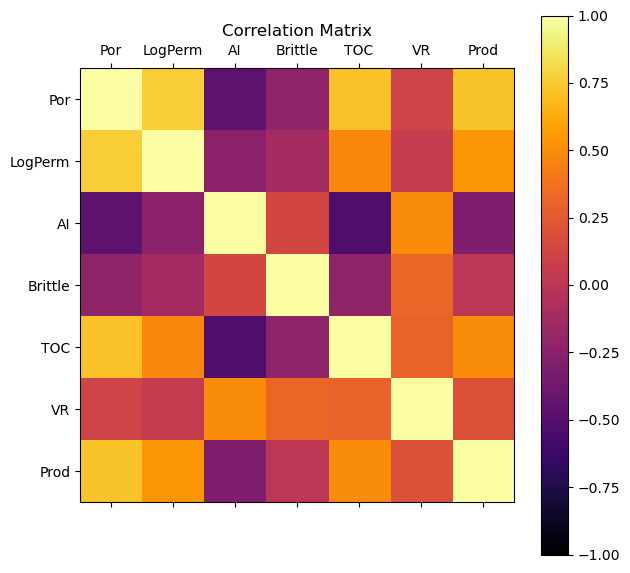

In [12]:
plot_corr(df,7)                                      # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the Pandas package. 

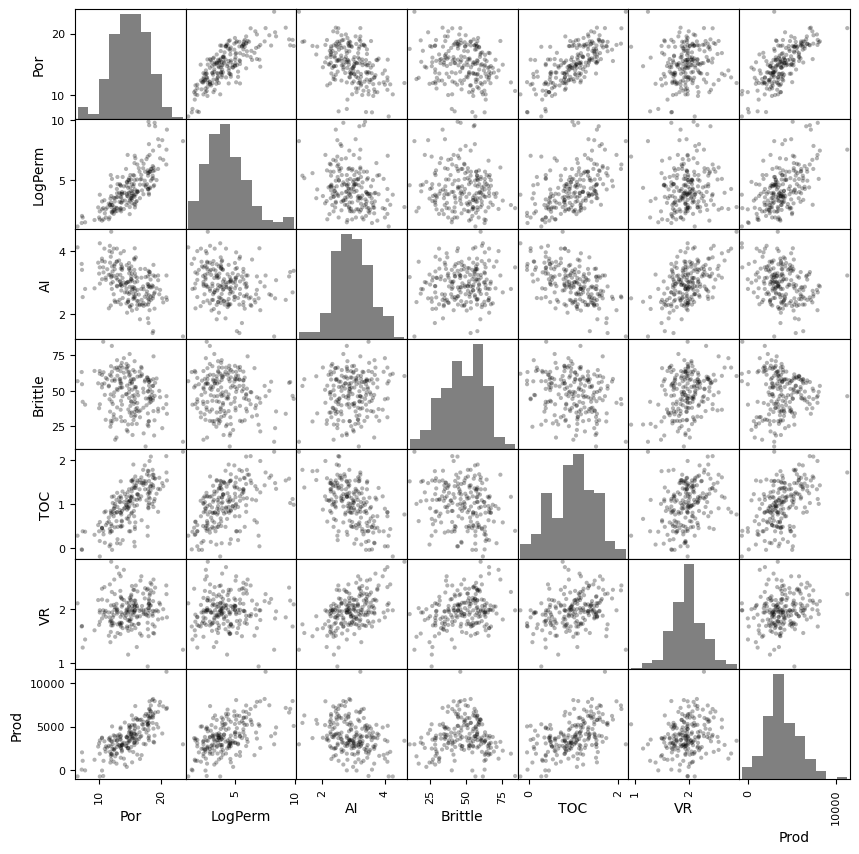

In [13]:
pd_plot.scatter_matrix(df, alpha = 0.3,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

#### Working with Only Two Features

Let's simplify the problem to 2 features.

* we will select proppant and pore pressure based on the previous feature ranking exercise

* by changing the feature index below you can select your own predictor features.

In [14]:
ix1 = 1                                               # predictor features column numbers
ix2 = 3  

seed = 73073                                          # random number seed

# do not change the response feature below
iy = 6                                                # response feature column number

# checks
if ix1 == ix2: print('WARNING - you cannot use the same feature twice to make a prediction model'); assert(False)
if iy != 6: print('WARNING - this workflow is designed to predict production, set as the response feature'); assert(False)
if ix1 == 6 or ix2 == 6: print('Warning - you cannot use the response feature as a predictor feature'); assert(False)

df_sub = df.iloc[:,[ix1,ix2,iy]]                      # extract just por, brittle and prod with 100 samples
df_sub.describe().transpose()                         # calculate summary statistics for the data
f1 = features[ix1]; f2 = features[ix2]; fy = features[iy]
u1 = units[ix1]; u2 = units[ix2]; uy = units[iy]
min1 = fmin[ix1]; min2 = fmin[ix2]; miny = fmin[iy]
max1 = fmax[ix1]; max2 = fmax[ix2]; maxy = fmax[iy]

predictors = df_sub.iloc[:,[0,1]]; response = df_sub.iloc[:,[2]]   # training and testing together
X_train, X_test, y_train, y_test = train_test_split(predictors,response, test_size=0.25, random_state=seed)

predictors = df_sub.iloc[:,:2]; response = pd.DataFrame({fy:df_sub.iloc[:,2]})

print('Your selected model features: \nPredictor Features: ' + f1 + ' and ' + f2 + '\nResponse Feature: ' + fy)

Your selected model features: 
Predictor Features: LogPerm and Brittle
Response Feature: Prod


Let's first check the univariate statistics of the selected features X1, X2 and y.

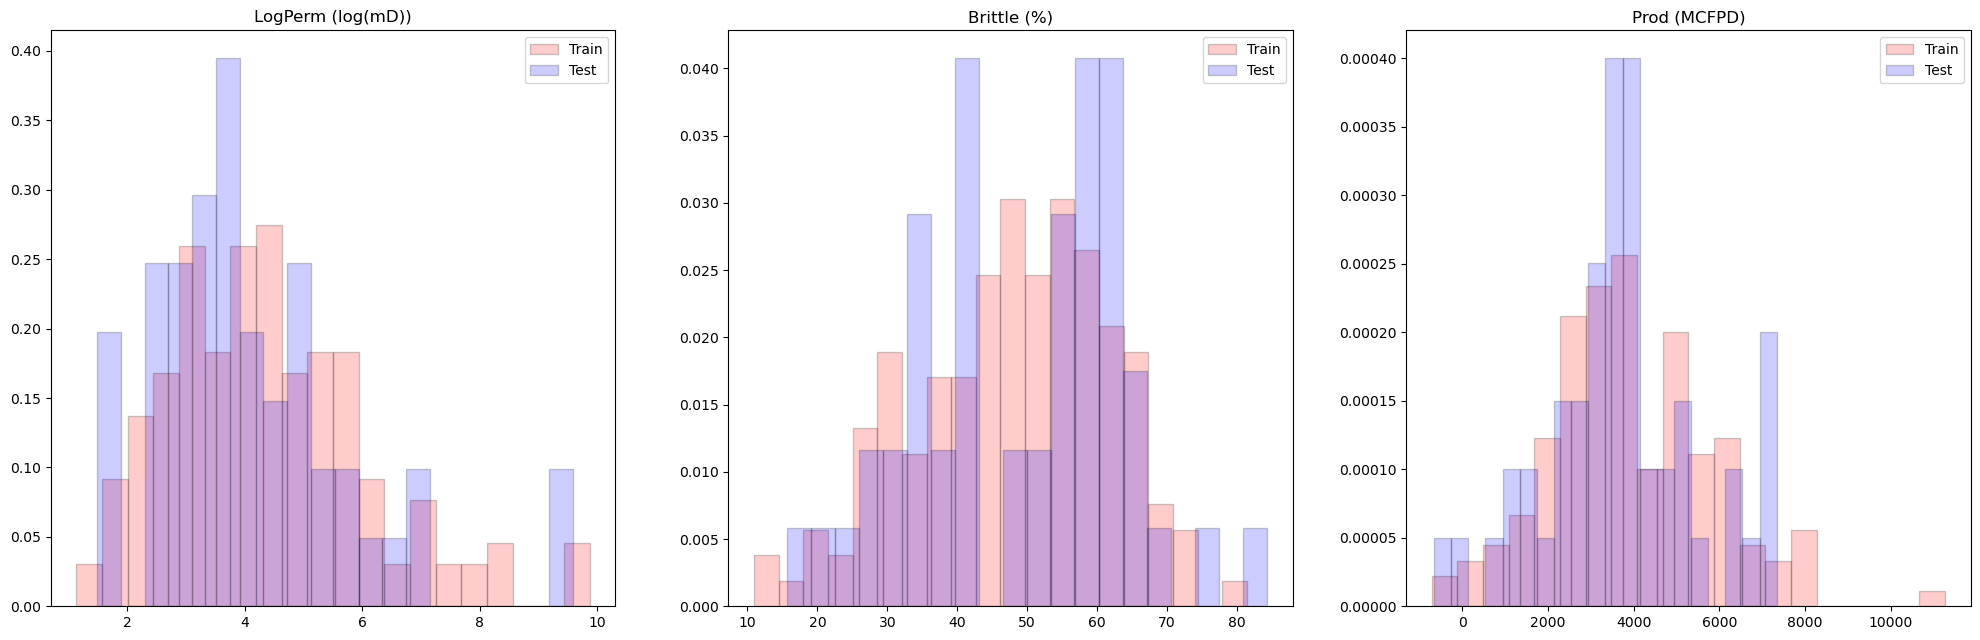

In [15]:
plt.subplot(131)
plt.hist(X_train[f1], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20, density = True, label = 'Train')
plt.hist(X_test[f1], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20, density = True, label = 'Test')
plt.title(f1 + ' (' + u1 + ')'); plt.legend()

plt.subplot(132)
plt.hist(X_train[f2], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20, density = True, label = 'Train')
plt.hist(X_test[f2], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20, density = True, label = 'Test')
plt.title(f2 + ' (' + u2 + ')'); plt.legend()

plt.subplot(133)
plt.hist(y_train[fy], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20, density = True, label = 'Train')
plt.hist(y_test[fy], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20, density = True, label = 'Test')
plt.title(fy + ' (' + uy + ')');  plt.legend()

y_min = round(min(df_sub[fy]),0); y_max = round(max(df_sub[fy]),0)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  

Let's look at a scatter plot of Porosity vs. Brittleness with points colored by Production.

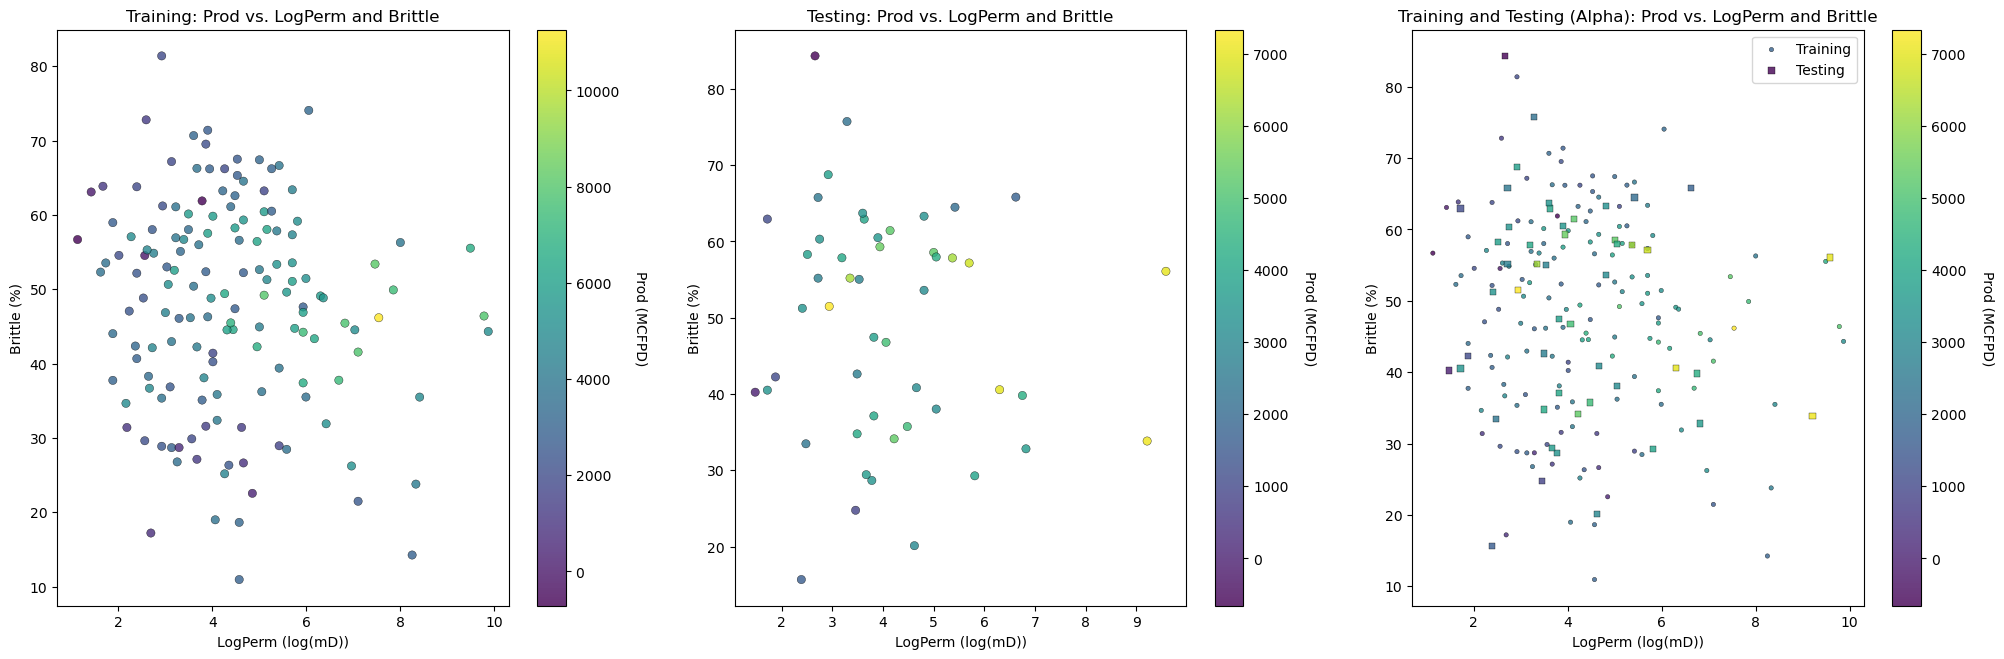

In [17]:
plt.subplot(131)
im = plt.scatter(X_train[f1],X_train[f2],s=None, c=y_train[fy], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Training: ' + fy + ' vs. ' + f1 + ' and ' + f2); plt.xlabel(f1 + ' (' + u1 + ')'); plt.ylabel(f2 + ' (' + u2 + ')')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(fy + ' (' + uy + ')', rotation=270, labelpad=20)

plt.subplot(132)
im = plt.scatter(X_test[f1],X_test[f2],s=None, c=y_test[fy], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing: ' + fy + ' vs. ' + f1 + ' and ' + f2); plt.xlabel(f1 + ' (' + u1 + ')'); plt.ylabel(f2 + ' (' + u2 + ')')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(fy + ' (' + uy + ')', rotation=270, labelpad=20)

plt.subplot(133)
im = plt.scatter(X_train[f1],X_train[f2],s=10, c=y_train[fy], marker='o',cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Training')
im = plt.scatter(X_test[f1],X_test[f2],s=20, c=y_test[fy], marker='s', cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Testing')
plt.title('Training and Testing (Alpha): ' + fy + ' vs. ' + f1 + ' and ' + f2); plt.xlabel(f1 + ' (' + u1 + ')'); plt.ylabel(f2 + ' (' + u2 + ')')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(fy + ' (' + uy + ')', rotation=270, labelpad=20)
plt.legend(loc = 'upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

This problem looks complicated and could not be modeled with simple linear regression.  It appears there is a sweet spot for Brittleness and increasing Porosity is always beneficial for Production.

#### Calculation of a Decision Tree

The input for the decision tree is 2 DataFrames, one with the predictors / features and the other with the response variable.  We will use the DataFrame member function copy() to copy the respective columns to 2 new DataFrames.  

* we already have our DataFrames separated by train and test, and predictors (X) and response features (y)

* the first step is to instantiate the decision tree and set the hyperparameter(s) to constrain complexity

    * **min_samples_leaf** is the minimum number of training data in a region
    * **max_depth** is the maximum tree depth, maximum number of levels, e.g. 1 decision is one level resulting in 2 regions
    * **max_leaf_nodes** is the maximum number of regions

You can select the hyperparameter to use by uncommenting the specific line of code.

D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Training Performance:
Mean Squared Error =  1434104.66 , Correlation Coefficient =  0.79


D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Testing Performance:
Mean Squared Error =  2301249.24 , Correlation Coefficient =  0.53


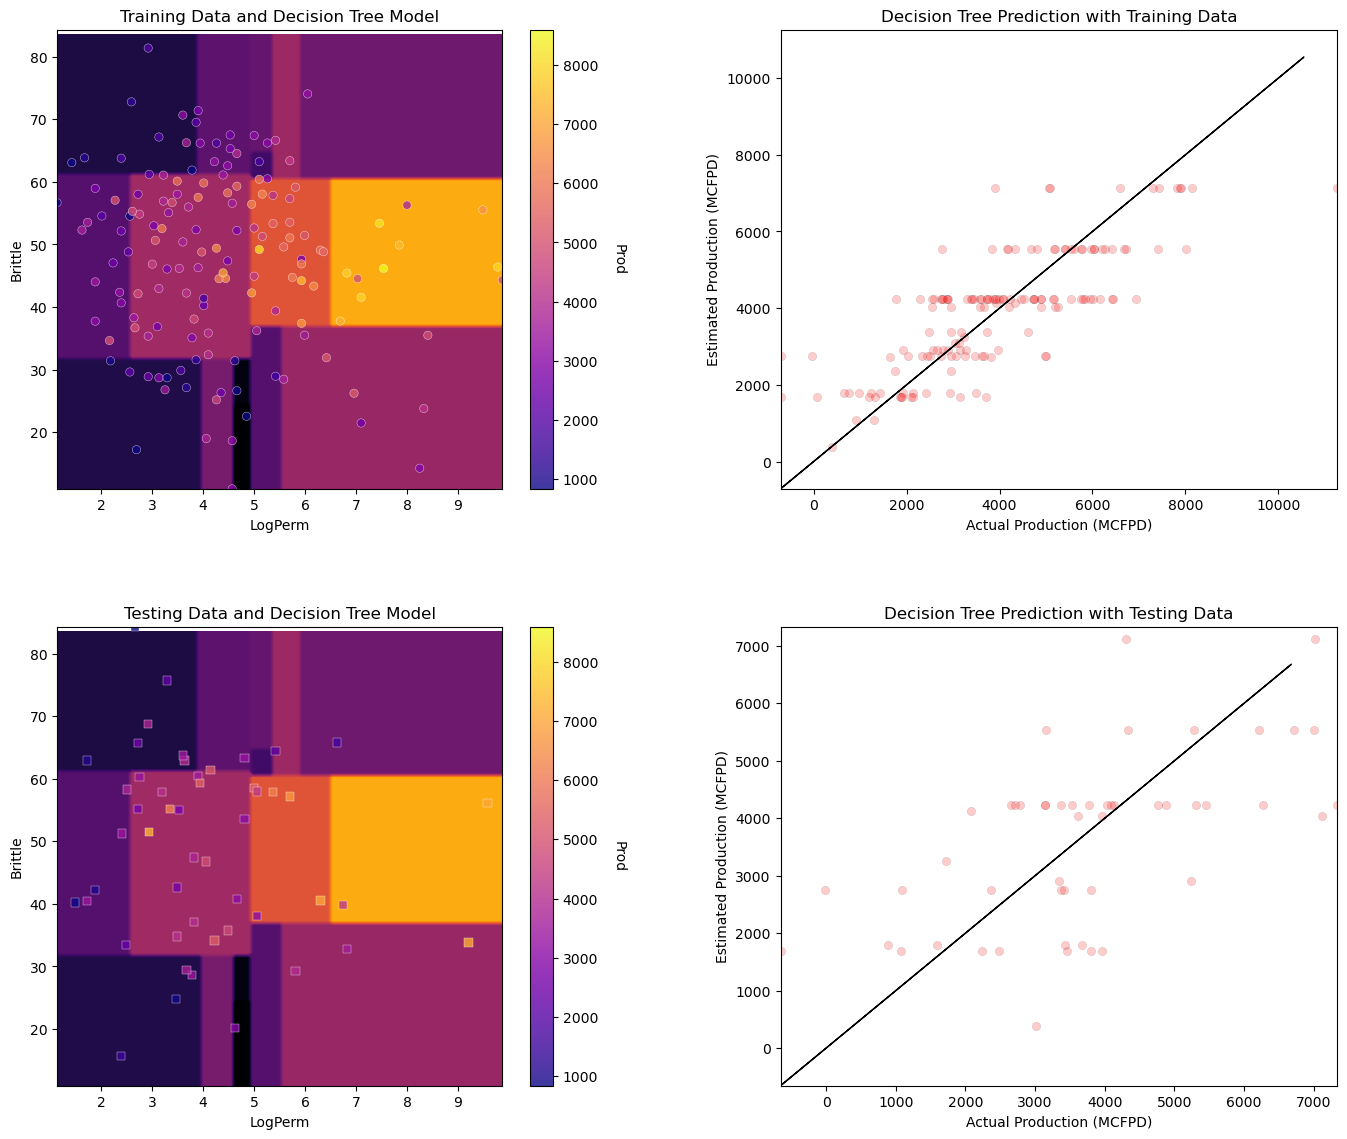

In [20]:
#my_tree = tree.DecisionTreeRegressor(min_samples_leaf=5) # instantiate a decision tree regression model
my_tree = tree.DecisionTreeRegressor(max_depth = 4) 
#my_tree = tree.DecisionTreeRegressor(max_leaf_nodes = 2)
my_tree = my_tree.fit(X_train, y_train)

plt.subplot(221)
visualize_tree(my_tree,X_train[f1],min1,max1,X_train[f2],min2,max2,y_train[fy],miny,maxy,'Training Data and Decision Tree Model','o',)

print('Training Performance:')

plt.subplot(222)
check_model(my_tree,X_train[f1],X_train[f2],y_train[fy],'Decision Tree Prediction with Training Data')

plt.subplot(223)
visualize_tree(my_tree,X_test[f1],min1,max1,X_test[f2],min2,max2,y_test[fy],miny,maxy,'Testing Data and Decision Tree Model','s')

print('Testing Performance:')

plt.subplot(224)
check_model(my_tree,X_test[f1],X_test[f2],y_test[fy],'Decision Tree Prediction with Testing Data',)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

See the horizontal lines on the plot of estimated vs. actual production (plot on the bottom)? 

* That is expected as the regression tree estimates are the average of the data in each region of the feature space (terminal node). 

* If there are 8 terminal nodes, then there are only 8 possible values estimated by the decision tree.

I also provide the mean square error and variance explained ($R^2$, taken with a grain of salt as the nonlinearity of the decision tree, variance explained should only be used with linear models) over the training and testing data.

It is useful and instructive to visualize the tree. Check out the result below.  

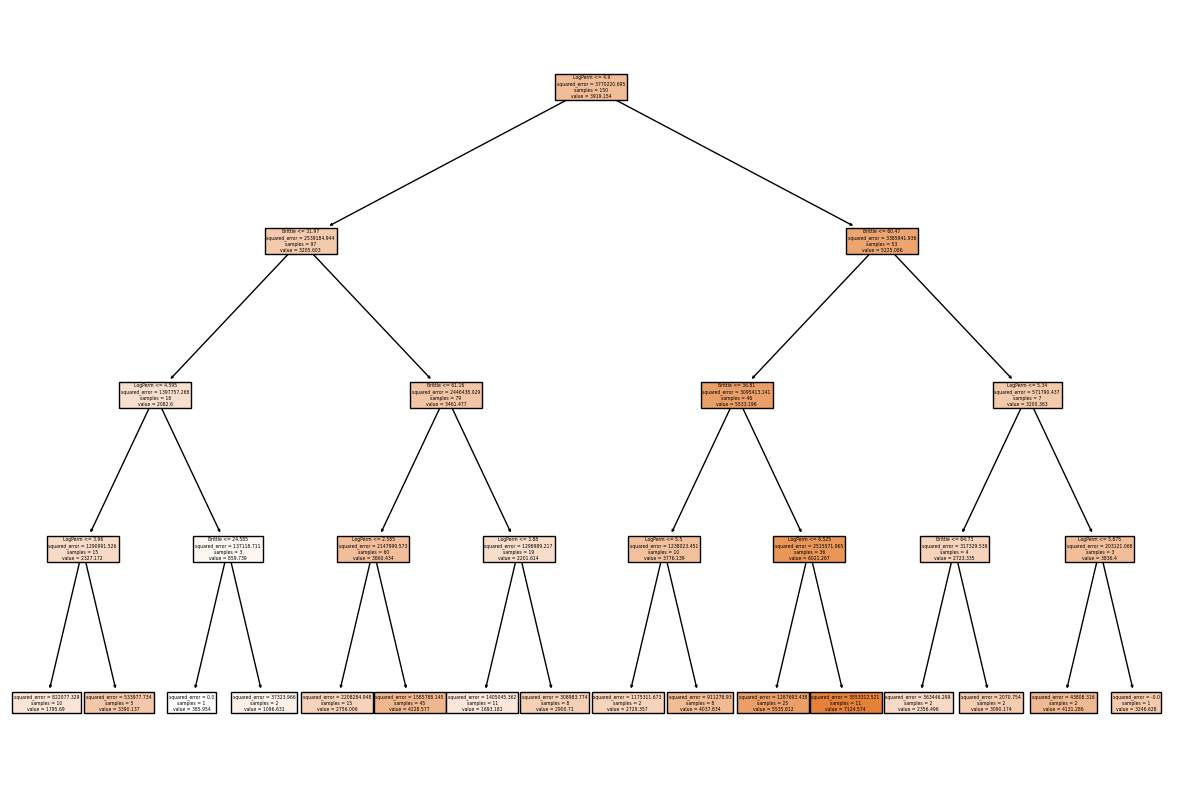

In [21]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(my_tree, 
                   feature_names=list([f1,f2]),  
                   class_names=list(fy),
                   filled=True)

If you used the **max_depth** or **max_leaf_nodes** you can readily confirm this constraint on your decision tree above.

* You can track through the binary decisions over the select 2 predictor feature to get to the region, terminal node, leaf node of the decision tree with the prediction (the average of the training data in the region).

#### Hyperparameter Tuning

This was a good excercise to make decision trees and play with the hyperparameters, but let's now build a good model, a model with accurate predictions for cases not used to build the model, with hyperparameter tuning.

I show hyperparameter tuning with:

* cross validation, use the withheld testing data to calculate the test mean square error over a range of decision trees from simple to complicated

* k-fold cross validation, use equal size 'k' folds of withheld testing data to calculate the test mean square error, and summarize over all 'k' folds over a range of decision trees from simple to complicated

We will use the **max_leaf_nodes** hyperparameter to control decision tree complexity.

* note the max leaf node (regions) = 5 is the max leaf node = 6 tree with the last branch removed.

By sequentially removing the last branch we get a set of simple to complicated decision tree models.

#### Hyperparameter Tuning by Cross Validation 

Let's start with cross validation over a range of model complexity, max leaf nodes from $2,\ldots,40$. 

* With the code below you can look at the models by setting this variable to True, or hide them by setting it to false.

```python
show_models = True
```

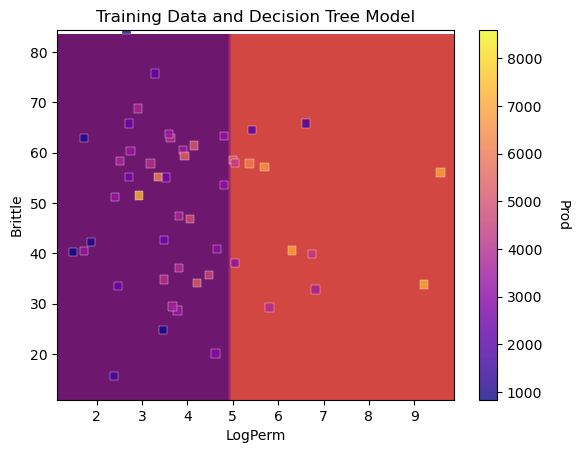

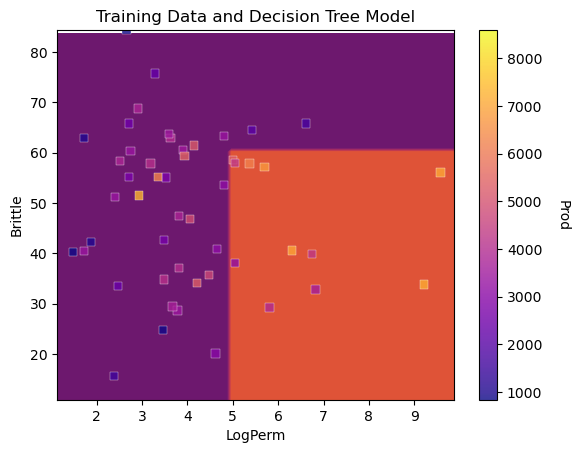

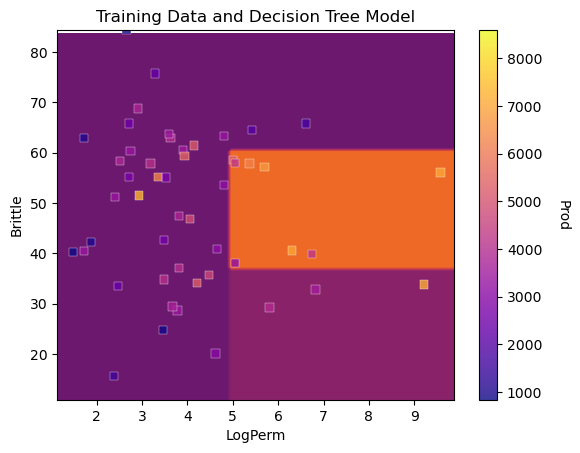

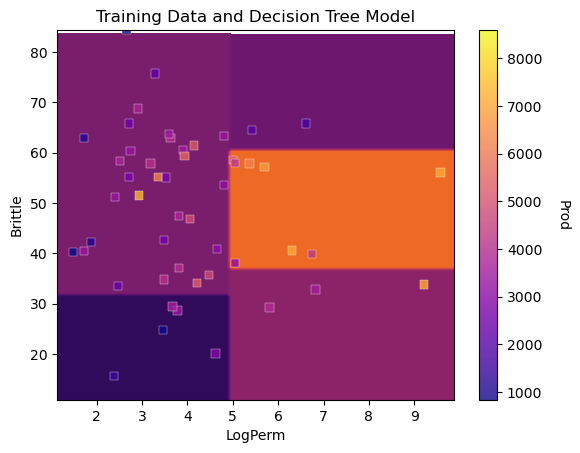

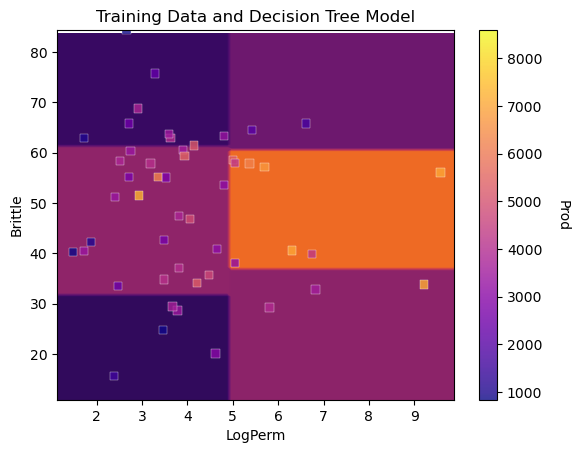

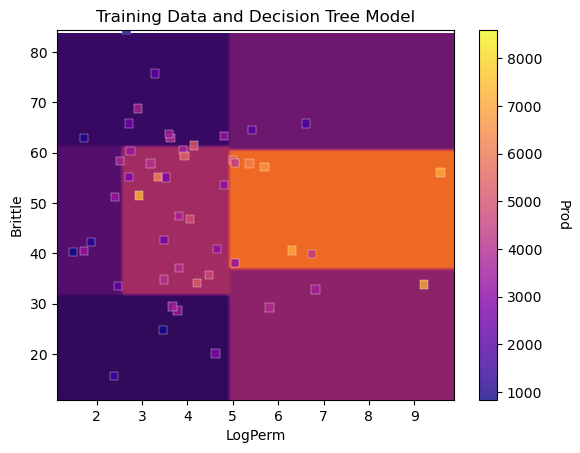

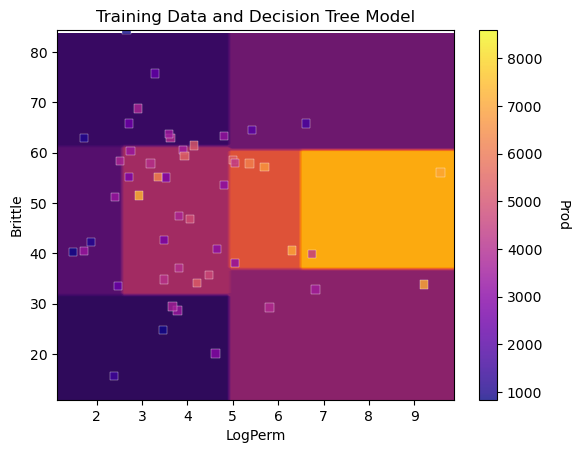

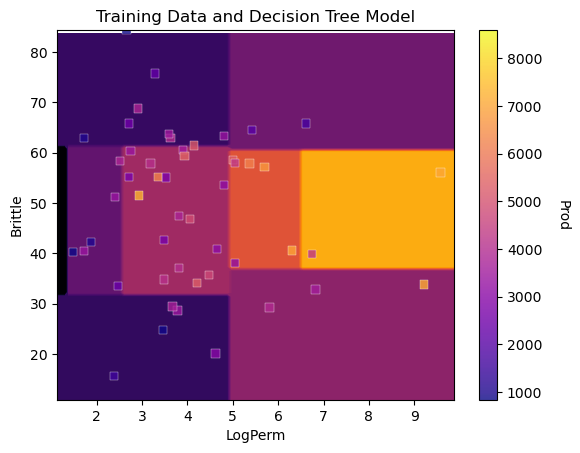

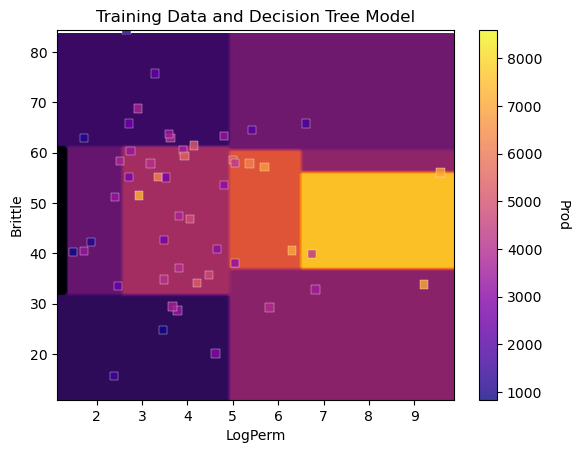

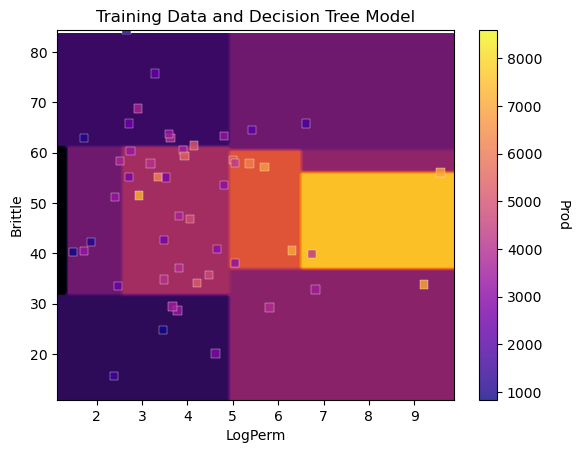

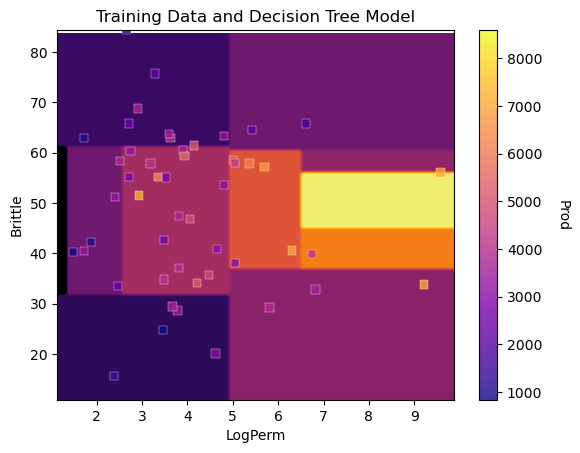

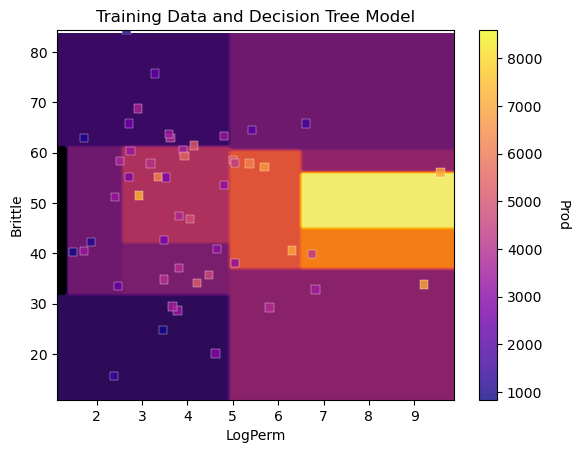

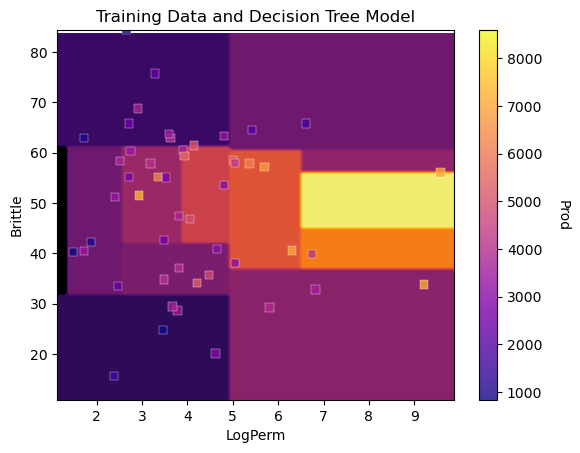

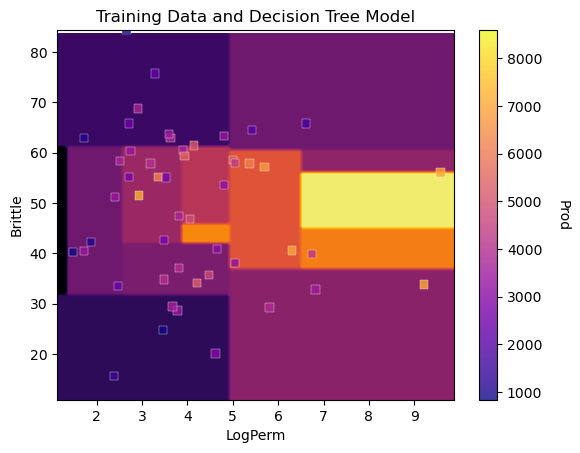

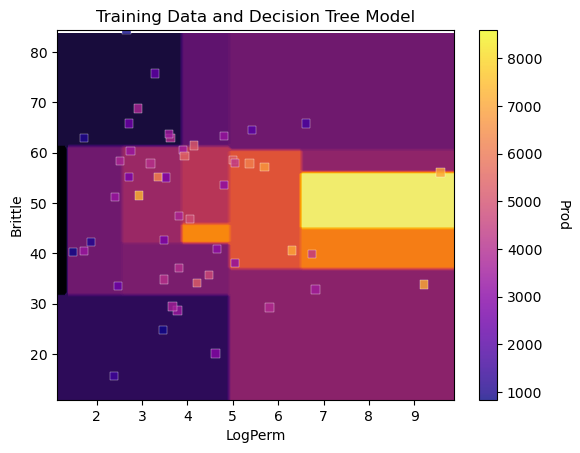

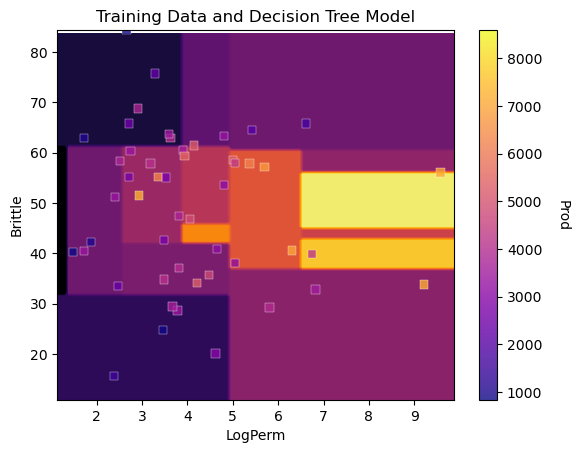

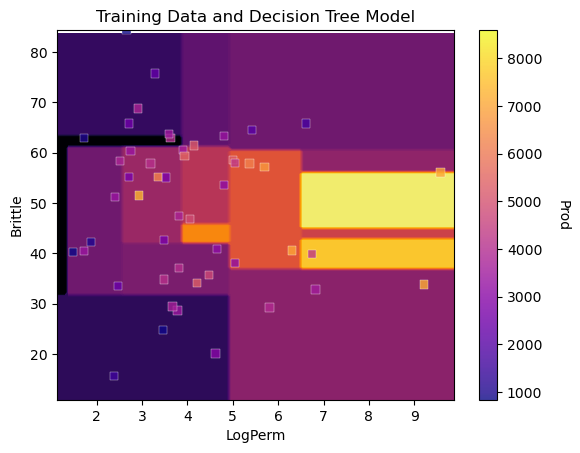

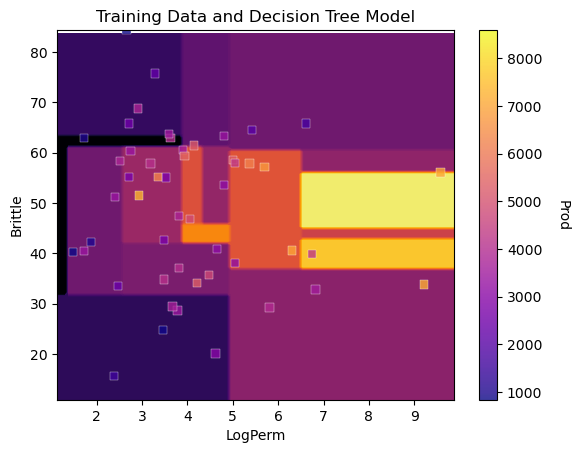

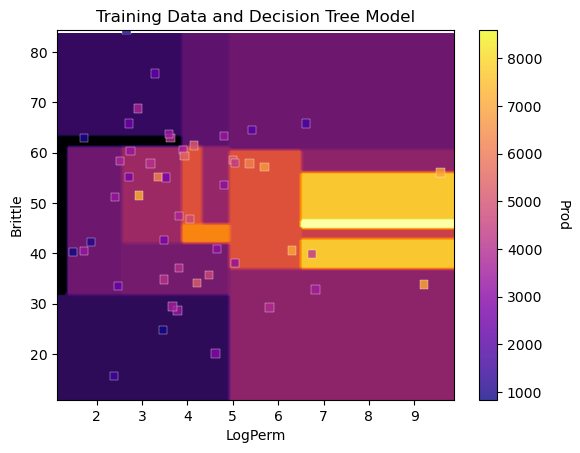

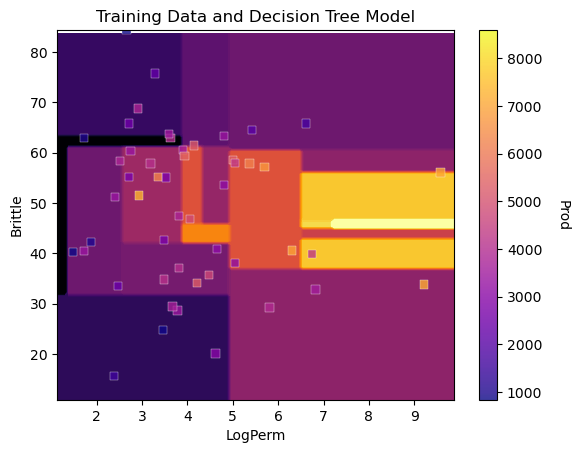

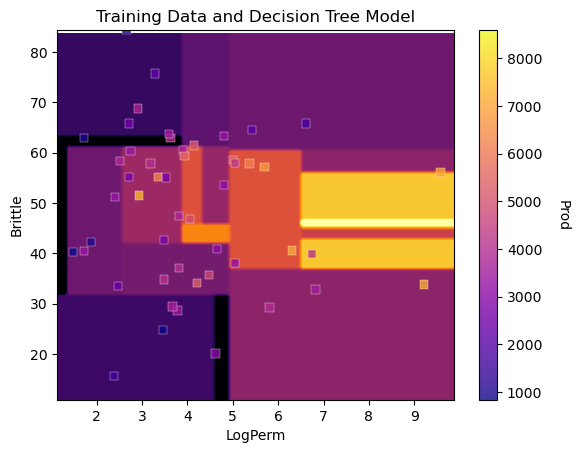

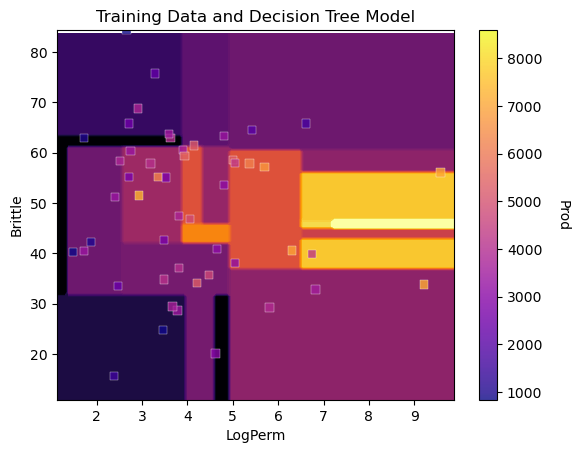

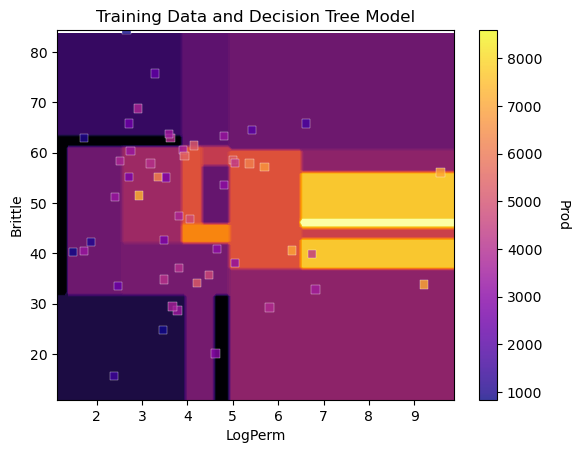

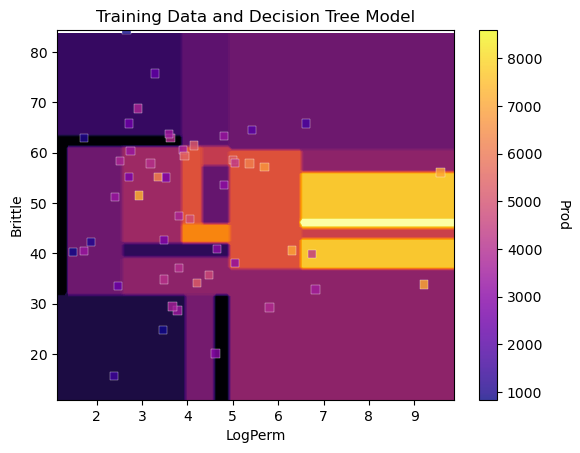

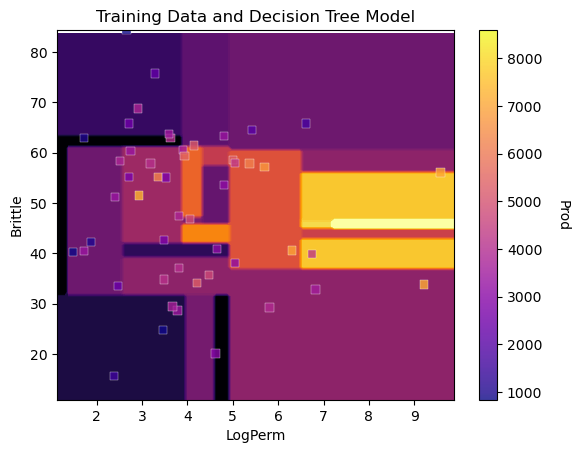

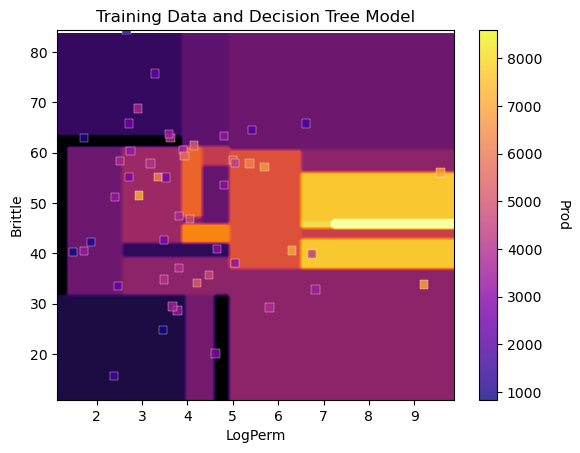

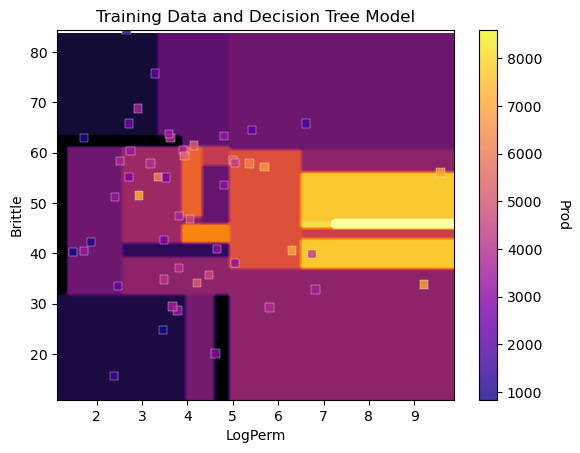

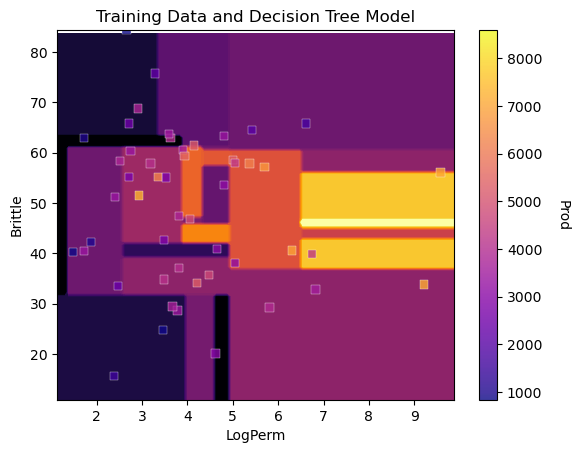

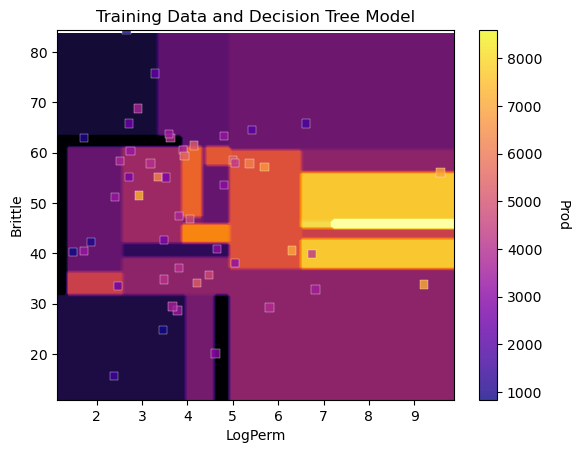

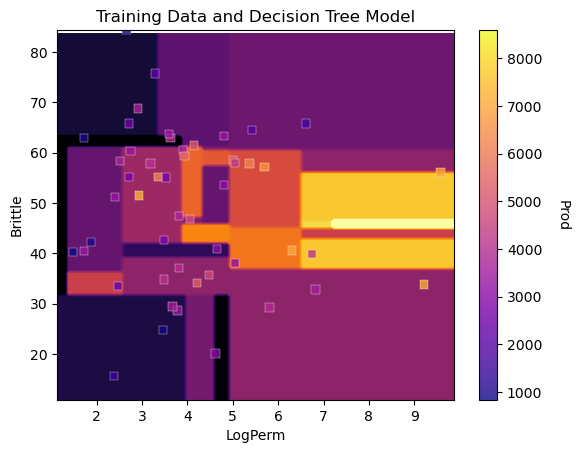

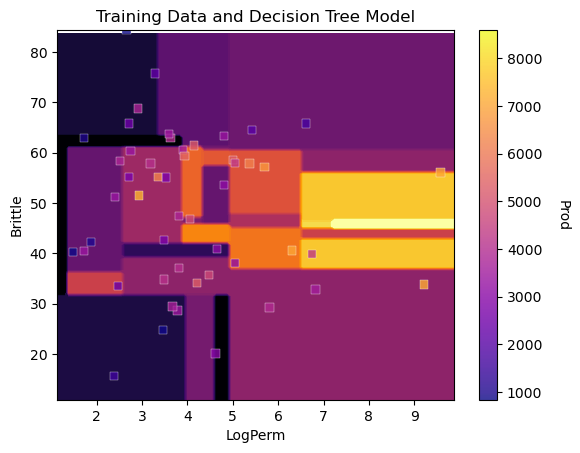

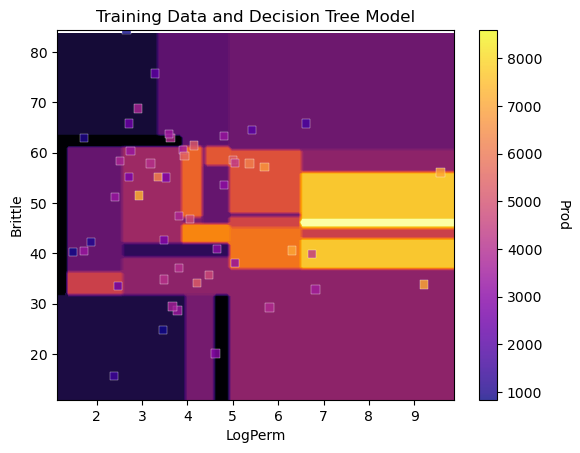

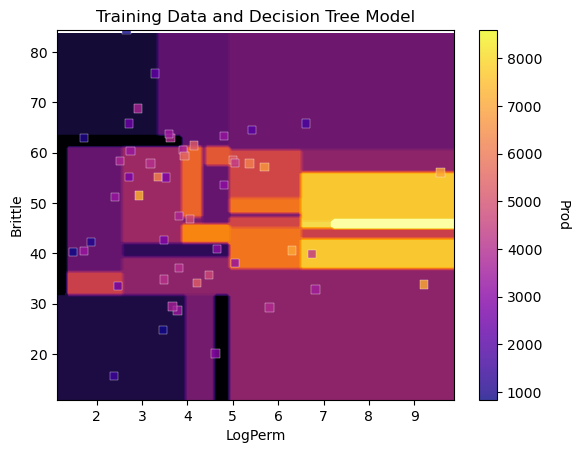

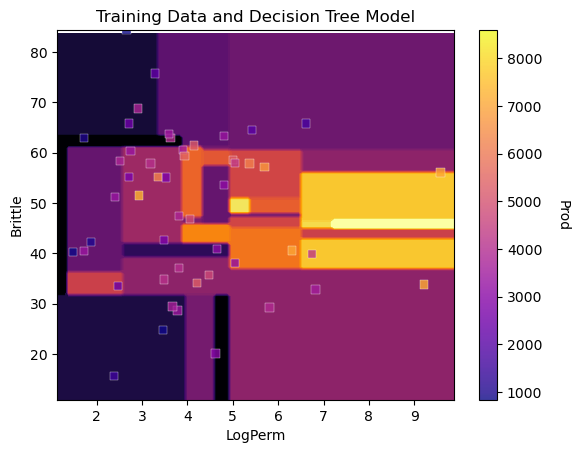

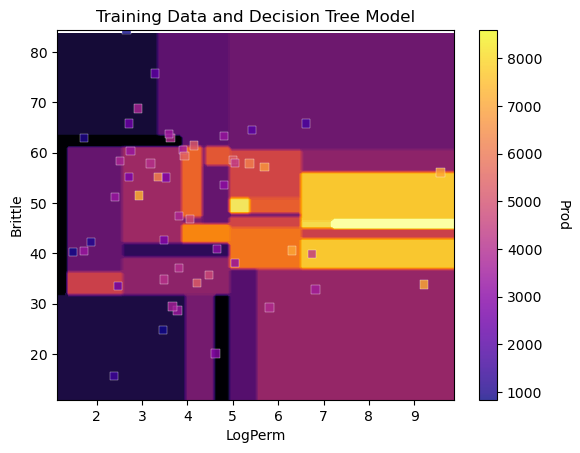

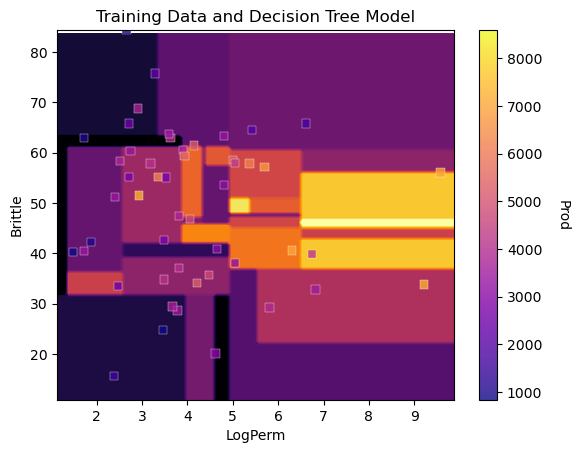

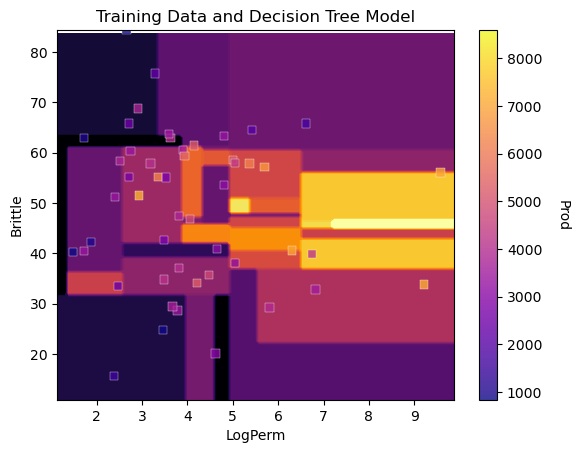

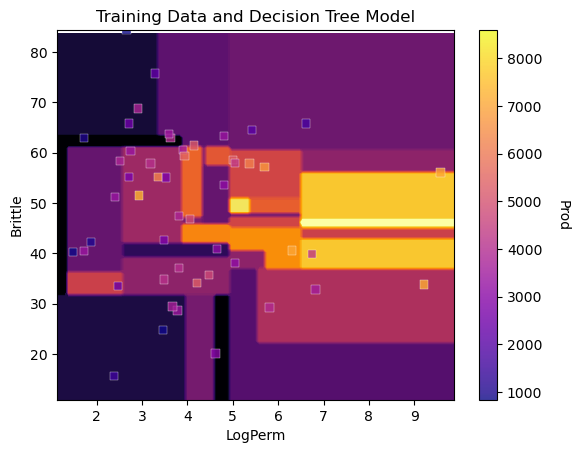

In [22]:
import warnings
warnings.filterwarnings('ignore')

show_models = True

trees = []
error = []
var_exp = [] 
nodes = []

inodes = 2
max_nodes = 40
while inodes < max_nodes:
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=inodes)
    my_tree = my_tree.fit(X_train, y_train)
    trees.append(my_tree)
    
    if show_models:
        plt.subplot(111)
        visualize_tree(my_tree,X_test[f1],min1,max1,X_test[f2],min2,max2,y_test[fy],miny,maxy,'Training Data and Decision Tree Model','s',)
        plt.show()
    
    predict_test = my_tree.predict(np.c_[X_test[f1],X_test[f2]])
    
    error.append(metrics.mean_squared_error(y_test[fy],predict_test))
    var_exp.append(metrics.explained_variance_score(y_test[fy],predict_test))    

    all_nodes = my_tree.tree_.node_count             
    decision_nodes = len([x for x in my_tree.tree_.feature if x != _tree.TREE_UNDEFINED]) 
    terminal_nodes = all_nodes - decision_nodes
    nodes.append(terminal_nodes)
    
    inodes+=1

Let's now plot the testing mean square error vs. the number of regions, leaf nodes.

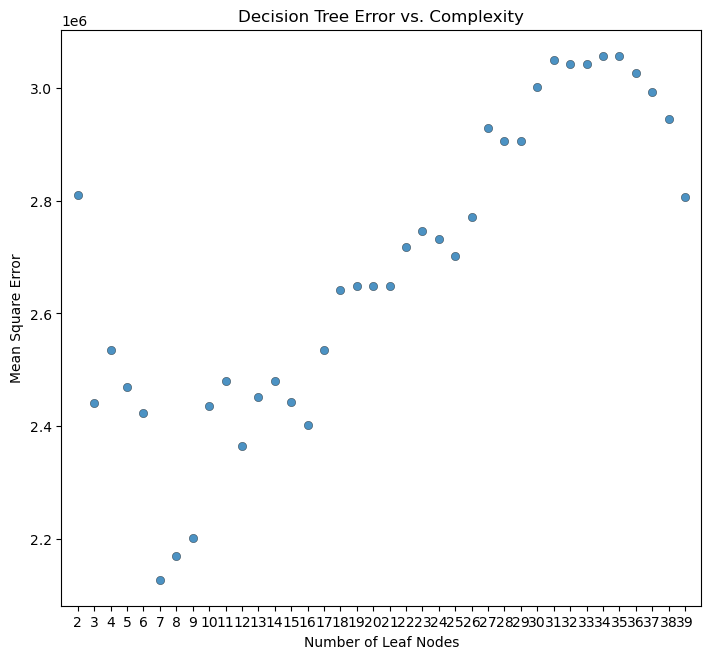

In [23]:
plt.subplot(111)
plt.scatter(nodes,error,s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Decision Tree Error vs. Complexity'); plt.xlabel('Number of Leaf Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(1,max_nodes); plt.xticks(np.arange(2, max_nodes, step=1.0))  # Set label locations. #plt.ylim(0,1500000)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

It is useful to evaluate the performance of our tree by observing the accuracy vs. complexity trade-off.  Also, it was useful for us to observed the tree model over the feature space as we incrementally add terminal nodes. We can graphically observe the hierarical binary splitting quite clearly.  

#### k-fold Cross Validation

For a more robust assessment of our model let's use k-fold cross valdiation. The scikit-learn Python package has a built in cross validation method with k-fold cross validation called cross_val_score that we can use to:

1. Apply k-fold approach with iterative separation of training and testing data
2. Automate the model construction, looping over folds and averaging the error metric of interest. Note all the scores for each fold are returned so we average over the folds.

Let's try it out on our trees with variable number of terminal nodes. Note the cross validation is set to use 4 processors, but still will likely take a couple of minutes to run.

In [24]:
score = []                      
node = []
for inodes in range(2,max_nodes):
    my_tree = tree.DecisionTreeRegressor(max_leaf_nodes=inodes) 
    scores = cross_val_score(estimator=my_tree, X= np.c_[df_sub[f1],df_sub[f2]],y=df_sub[fy], cv=5, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    node.append(inodes)

The output is an array of average scores (MSE) over the k-folds for each level of complexity (number of terminal nodes) and the maximum number of terminal nodes parameter in another array.

* we show the plot below to assist with selection of the optimum model complexity, hyperparameter tuning 

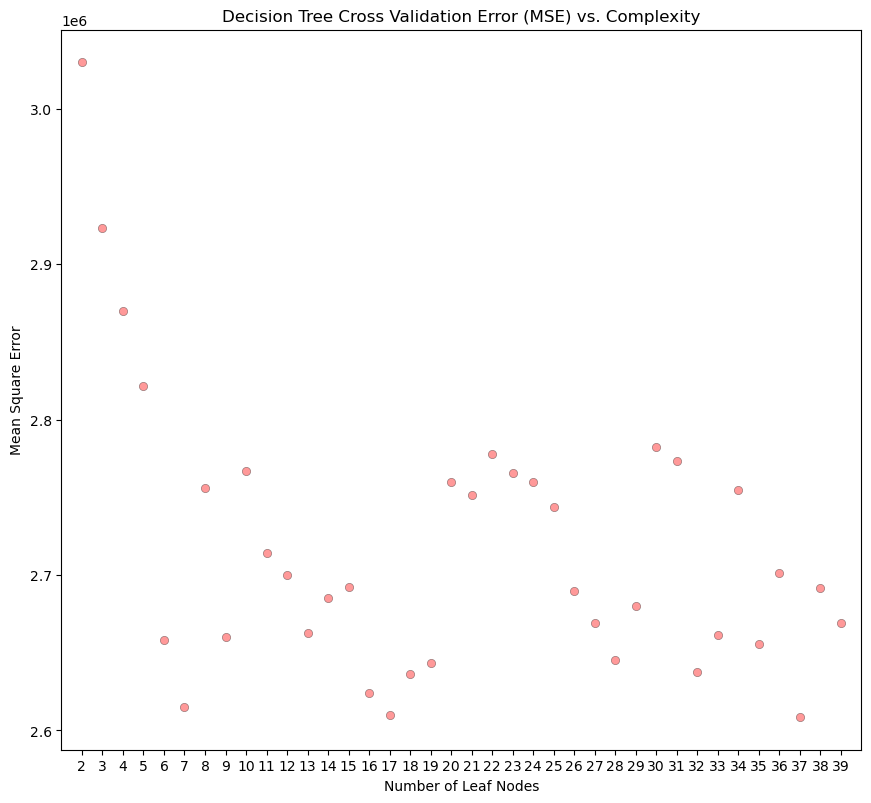

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(node,score,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.4, linewidths=0.5, edgecolors="black")
plt.title('Decision Tree Cross Validation Error (MSE) vs. Complexity'); plt.xlabel('Number of Leaf Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(1,max_nodes); plt.xticks(np.arange(2, max_nodes, step=1.0))  

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

#### Build the Pruned Decision Tree Model

Now that we have identified the optimum hyperparameter, model complexity we can build our machine learning prediction model, our purned decision tree.

* we set the hyperparameter and retrain our model with all of our data combined

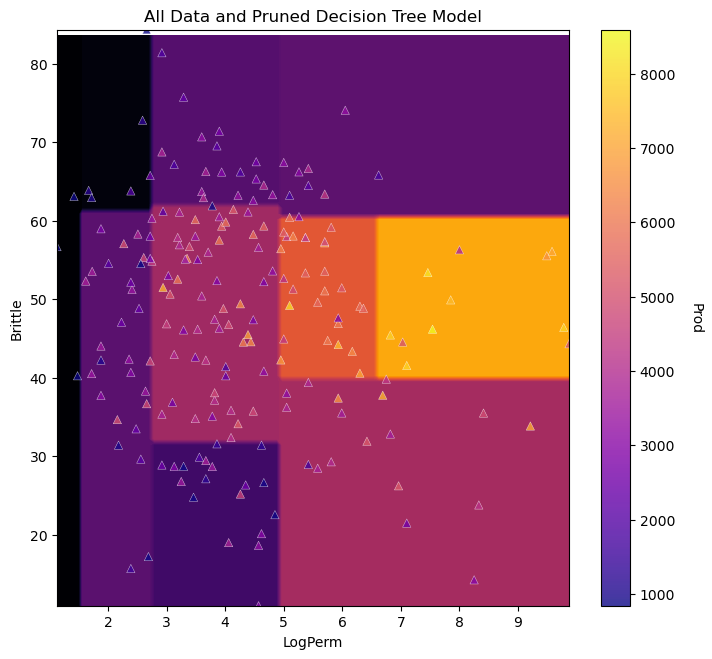

In [26]:
my_pruned_tree = tree.DecisionTreeRegressor(max_leaf_nodes=10)
my_pruned_tree = my_pruned_tree.fit(predictors, response)

plt.subplot(111)
visualize_tree(my_pruned_tree,predictors[f1],min1,max1,predictors[f2],min2,max2,response[fy],miny,maxy,'All Data and Pruned Decision Tree Model','^',)


plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()


Let's cover a couple more interesting topics. 

#### Interogating Our Pruned Decision Tree

It may be useful to evaluate for any possible feature combination, the order of decision nodes that resulted in the specific prediction.  The following function provides the list of nodes and decision 1 is $\le$ and 0 is $\gt$. We start at node 0 and traverse the series of splits to reach the prediction.

In [27]:
decision_path = my_pruned_tree.decision_path(np.c_[10.0,30.0])
print(decision_path)

  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (0, 7)	1


#### Convert Our Pruned Decision Tree into a Function

Furthermore it may be useful to convert the decision tree to a Python function, a nested set of if statements.  

* This creates a portable model that could be copied and applied as a standalone function.  

* Also, one could conveniently interogate the code version of the tree.  

* We use the previously defined function to do this with our pruned tree.

In [28]:
tree_to_code(my_pruned_tree, list(features))

def tree(Por, LogPerm, AI, Brittle, TOC, VR, Prod):
  if Por <= 4.8999998569488525:
    if Por <= 2.7050000429153442:
      if Por <= 1.550000011920929:
        return [[-215.79002982]]
      elif Por > 1.550000011920929
        if LogPerm <= 60.954999923706055:
          return [[2869.00008936]]
        elif LogPerm > 60.954999923706055
          return [[966.15915276]]
    elif Por > 2.7050000429153442
      if LogPerm <= 31.969999313354492:
        return [[2348.93527611]]
      elif LogPerm > 31.969999313354492
        if LogPerm <= 61.65999984741211:
          return [[4196.32777528]]
        elif LogPerm > 61.65999984741211
          return [[2726.69951895]]
  elif Por > 4.8999998569488525
    if LogPerm <= 60.46999931335449:
      if LogPerm <= 40.19000053405762:
        return [[4318.51180251]]
      elif LogPerm > 40.19000053405762
        if Por <= 6.590000152587891:
          return [[5622.48362488]]
        elif Por > 6.590000152587891
          return [[7099.01252478]]
   

#### Feature Importance from Our Pruned Decision Tree

Let's check the Gini importance measure, a measure of feature importance built into (member variable of the tree class) our decision tree model  

* This is normalized, total reduction mean squared error due to inclusion of the variable.

In [29]:
print(f1 + ' Importance = ' + str(round(my_pruned_tree.feature_importances_[0],2)) + ',' + f2 + ' Importance = ' + str(round(my_pruned_tree.feature_importances_[1],2)))

LogPerm Importance = 0.58,Brittle Importance = 0.42


#### Visualizing our Pruned Decision Tree

Let's take a last look at the graphical representation of our pruned tree.  

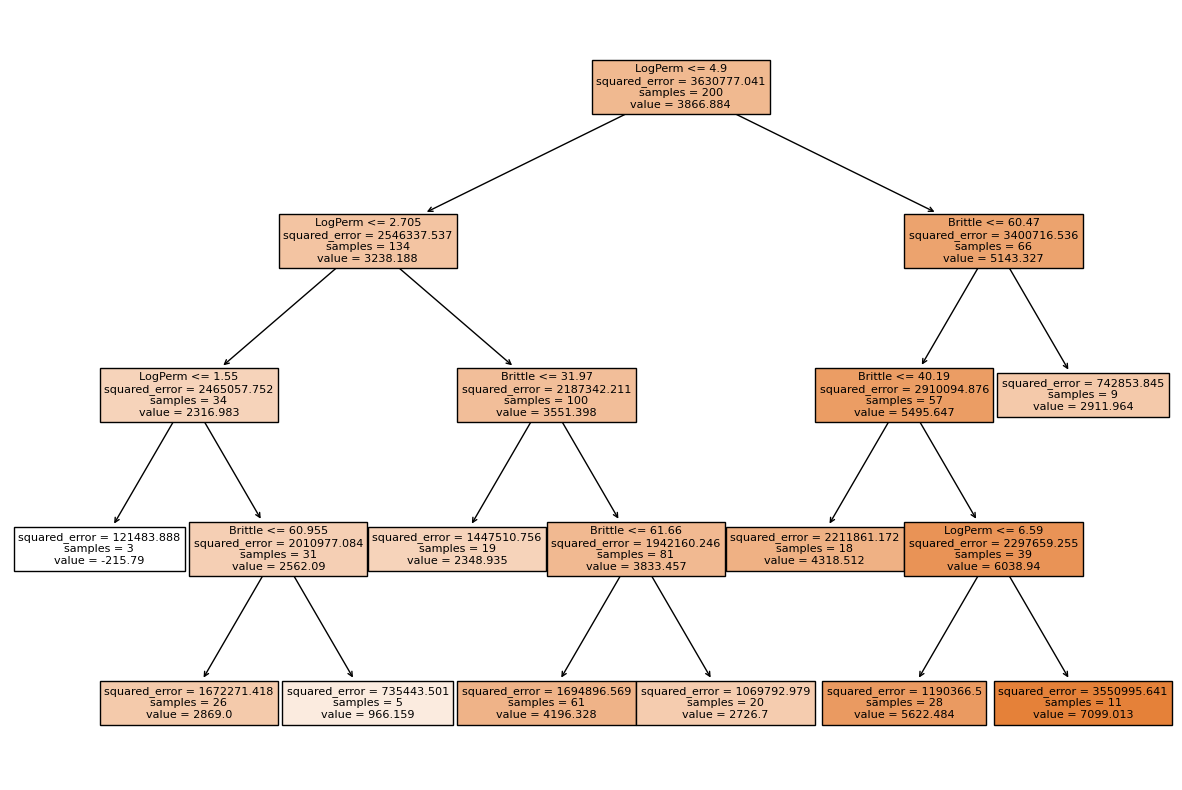

In [30]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(my_pruned_tree, 
                   feature_names=list([f1,f2]),  
                   class_names=list(fy),
                   filled=True)

Note the discret nature of the decision tree predictions.

#### General Model Workflow

This is a general workflow for any number of predictor features.

* we loose the ease to visualize the model

* tune model with k-fold cross validation on all training data (combined train and validation data)

* rebuild model with all training data (combined train and validation data) with identified hyperparameters

* test the model on withheld testing data

We return to the original data set, and select more features for an improved model based on feature selection.

* here's a reminder of the available features

In [31]:
print('All features = ' + str(df.columns))

All features = Index(['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod'], dtype='object')


Now we can select the most important features and train, tune and test our model.

In [32]:
iselected_predictors = [1,2,3,4,5]
selected_predictors = list(map(features.__getitem__, iselected_predictors))
selected_predictors_units = list(map(units.__getitem__, iselected_predictors))
df_subset2 = df.iloc[:,iselected_predictors]                    # extract just proppant and pore pressure
df_subset2.describe().transpose()                   # calculate summary statistics for the data

print('Selected predictor features = ' + str(selected_predictors) + '.')
print('Response feature = ' + str(fy) + '.')

Selected predictor features = ['LogPerm', 'AI', 'Brittle', 'TOC', 'VR'].
Response feature = Prod.


Now we can tune the model hyperparameters

* there are a variety of options for hyperparmaeters and metrics to try out

In [34]:
max_nodes = 100
score_all = []                     # modified form code from StackOverFlow by Dimosthenis
node = []
for inodes in range(2,max_nodes):
    more_features_tree = tree.DecisionTreeRegressor(max_leaf_nodes=inodes) 
    scores_all = cross_val_score(estimator=more_features_tree,X= df_subset2,y=response, cv=4, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    #scores_all = cross_val_score(estimator=my_tree_all, X= X_train_all,y=y_train_all, cv=15, n_jobs=4,scoring = "explained_variance") # Perform 7-fold cross validation  
    score_all.append(abs(scores_all.mean()))
    node.append(inodes)

and now we can look at the model accuracy vs. complexity.

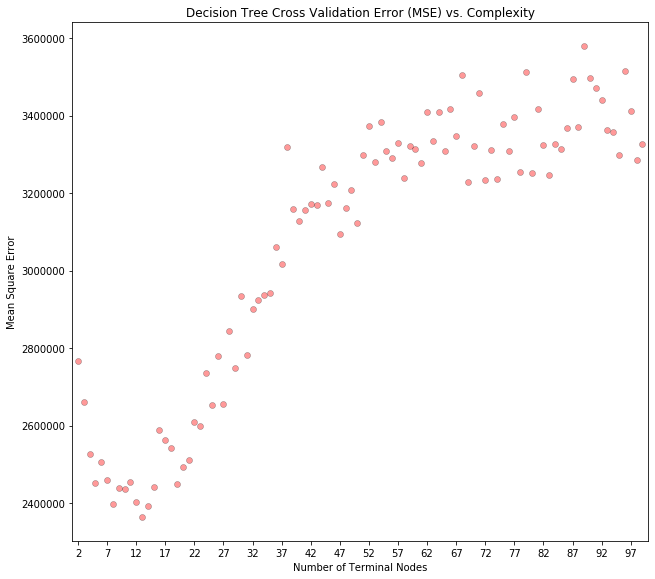

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(node,score_all,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.4, linewidths=0.5, verts=None, edgecolors="black")
plt.title('Decision Tree Cross Validation Error (MSE) vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xlim([1,max_nodes]); plt.xticks(np.arange(2, max_nodes, step=5.0))  
#plt.ylim([5.0e10,1.0e11]); plt.yscale("log")
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

Now we can select the hyperparmeter and train our decision tree model.

In [29]:
my_pruned_tree_all = tree.DecisionTreeRegressor(max_leaf_nodes=12)
my_pruned_tree_all = my_pruned_tree_all.fit(X= df_subset2,y=response)

There are so many more exercised and tests that one could attempt to gain experience with decison trees. I'll end here for brevity, but I invite you to continue. Consider, on your own apply other data sets or attempting modeling with random forest and boosting.  I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

#### Comments

This was a basic demonstration of decision trees for machine learning. Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  